tgb - 5/3/2021 - The goal is to develop the physical rescaling evaluation pre-training on the different buoyancies from Fiaz's papers.

tgb - 6/6/2021 - Another goal is to develop the climate-invariant figure showing the PDF of rescaled/non-rescaled variables for different simulations and climate

# Imports

In [1]:
import xarray as xr
import numpy as np
import math
import scipy.integrate as sin

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.transforms as mtrans
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.ticker import NullFormatter

import pickle

import warnings

from cbrain.cam_constants import *

In [2]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

# Compare buoyancy metrics sent by Fiaz

## Calculate histograms

In [3]:
def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))
def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)

    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

def theta_e_calc(T,qv,P0,PS,hyam,hybm):
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)

    tmelt  = 273.15
    CPD = 1005.7
    CPV = 1870.0
    CPVMCL = 2320.0
    RV = 461.5
    RD = 287.04
    EPS = RD/RV
    ALV0 = 2.501E6

    r = qv / (1. - qv)
    # get ev in hPa 
    ev_hPa = 100*p*r/(EPS+r)
    #get TL
    TL = (2840. / ((3.5*np.log(T)) - (np.log(ev_hPa)) - 4.805)) + 55.
    #calc chi_e:
    chi_e = 0.2854 * (1. - (0.28*r))
    P0_norm = (P0/(hyam*P0+hybm*PS))

    theta_e = T * P0_norm**chi_e * np.exp(((3.376/TL) - 0.00254) * r * 1000. * (1. + (0.81 * r)))

    return theta_e

def theta_e_sat_calc(T,qv,P0,PS,hyam,hybm):
    return theta_e_calc(T,qsat(T,P0,PS,hyam,hybm),P0,PS,hyam,hybm)

def bcons(T,qv,ilev,P0,PS,hyam,hybm,TNS,QNS):
    theta_env = theta_e_sat_calc(T,qv,P0,PS,hyam[ilev],hybm[ilev])
    return G*(theta_e_calc(TNS,QNS,P0,PS,hyam[29],hybm[29])-theta_env)/theta_env

# New definition from Fiaz
def bMSE(T,qv,ilev,P0,PS,hyam,hybm,TNS,QNS):
    R_V = 461.5
    qsat0 = qsat(T,P0,PS,hyam[ilev],hybm[ilev])
    kappa = 1+(L_V**2)*qsat0/(R_V*C_P*T**2)
    h_plume = C_P*TNS+L_V*QNS
    h_satenv = C_P*T+L_V*qsat0 
    return (G/kappa)*(h_plume-h_satenv)/(C_P*T)

def TfromNS(T,TNS):
    return TNS-T

In [4]:
ilev = 12 # Choose vertical level here

In [5]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [6]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

In [7]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
     '2021_06_03_RG_TRAIN_shuffle.nc',
     '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
     '2021_04_18_RG_TRAIN_P4K_shuffle.nc'
]

In [8]:
ishift = [0,0,0,-30,-30,-30]

In [9]:
train_data = {}

In [10]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'     ',end='\n')
    
    path_var = path_data + path 
    train_data[path] = xr.open_dataset(path_var)

ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc      
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc      
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc      
ipath= 3 path= 2021_06_03_RG_TRAIN_shuffle.nc      
ipath= 4 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc      
ipath= 5 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc      


In [11]:
hisT = {}
edgT = {}

for ikey,key in enumerate(['T','TfromNS','BMSE']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = {}
        edgT[key][path] = {}

In [12]:
Nbin = 100

In [26]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'ilev=',ilev)
    
    print('Load state variables')
    print('QV              ',end='\r')
    QV = train_data[path]['vars'][:,ilev]
    QV = QV.values
    print('TEMP              ',end='\r')
    TEMP = train_data[path]['vars'][:,30+ilev]
    TEMP = TEMP.values
    print('PS              ',end='\r')
    PS = train_data[path]['vars'][:,90+ishift[ipath]]
    PS = PS.values
    print('TNS             ',end='\r')
    TNS = train_data[path]['vars'][:,30+29]
    TNS = TNS.values
    print('QNS             ',end='\r')
    QNS = train_data[path]['vars'][:,29]
    QNS = QNS.values
    
    print('Calculate relevant rescalings')
    print('BCONS              ',end='\r')
    BCONS0 = bcons(TEMP,QV,ilev,P0,PS,hyam,hybm,TNS,QNS)
    print('TfromNS              ',end='\r')
    TfromNS0 = TfromNS(TEMP,TNS)
    print('BMSE               ',end='\r')
    BMSE0 = bMSE(TEMP,QV,ilev,P0,PS,hyam,hybm,TNS,QNS)
    
    print('Calculate histogram and assign it to histogram structure')
    for ikey,key in enumerate(['T','BCONS','TfromNS','BMSE']):
        if key=='T': his,edg = np.histogram(TEMP,bins=Nbin,density=True)
        elif key=='BCONS': his,edg = np.histogram(BCONS0,bins=Nbin,density=True)
        elif key=='TfromNS': his,edg = np.histogram(TfromNS0,bins=Nbin,density=True)
        elif key=='BMSE': his,edg = np.histogram(BMSE0,bins=Nbin,density=True)
        hisT[key][path] = his; edgT[key][path] = edg;

ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc ilev= 23
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc ilev= 23
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc ilev= 23
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 3 path= 2021_06_03_RG_TRAIN_shuffle.nc ilev= 23
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 4 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc ilev= 23
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 5 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc ilev= 23
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure


## Calculate and save histograms of b$_{MSE}$ separately as they require the full vertical profile

In [3]:
def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))
def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    S = T.shape;
    p = np.moveaxis(np.tile(P0,(30,1)),[0,1],[1,0]) *\
    np.moveaxis(np.tile(hyam,(1,1)),[0,1],[0,1]) + \
    np.moveaxis(np.tile(PS,(30,1)),0,1) * \
    np.moveaxis(np.tile(hybm,(1,1)),[0,1],[0,1])

    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

def bmse_calc(T,qv,P0,PS,hyam,hybm):
    eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
    R_D = 287 # Specific gas constant of dry air in J/K/kg
    Rv = 461
    # Calculate kappa
    QSAT0 = qsat(T,P0,PS,hyam,hybm)
    kappa = (1+(L_V**2)*QSAT0/(Rv*C_P*(T**2))).astype(np.float32)
    # Calculate geopotential
    r = qv/(qv**0-qv)
    Tv = T*(r**0+r/eps)/(r**0+r)
    S = Tv.shape;
    p = np.moveaxis(np.tile(P0,(30,1)),[0,1],[1,0]) *\
    np.moveaxis(np.tile(hyam,(1,1)),[0,1],[0,1]) + \
    np.moveaxis(np.tile(PS,(30,1)),0,1) * \
    np.moveaxis(np.tile(hybm,(1,1)),[0,1],[0,1])
    # Geopotential calculation below
    RHO = p/(R_D*Tv)
    Z = -sin.cumtrapz(x=p,y=1/(G*RHO),axis=1)
    Z = np.concatenate((0*Z[:,0:1]**0,Z),axis=1)
    # Assuming near-surface is at 2 meters
    Z = (Z-Z[:,[29]])+2 
    # Calculate MSEs of plume and environment
    Tile_dim = [1,30]
    h_plume = (np.tile(np.expand_dims(C_P*T[:,-1]+L_V*qv[:,-1],axis=1),Tile_dim)).astype(np.float32)
    h_satenv = (C_P*T+L_V*qv+G*Z).astype(np.float32)
    return (G/kappa)*(h_plume-h_satenv)/(C_P*T)

In [4]:
ilev = 23 # Choose vertical level here

In [5]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [6]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

In [7]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
     '2021_06_03_RG_TRAIN_shuffle.nc',
     '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
     '2021_04_18_RG_TRAIN_P4K_shuffle.nc'
]

In [8]:
ishift = [0,0,0,-30,-30,-30]

In [9]:
train_data = {}

In [10]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'     ',end='\n')
    
    path_var = path_data + path 
    train_data[path] = xr.open_dataset(path_var)

ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc      
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc      
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc      
ipath= 3 path= 2021_06_03_RG_TRAIN_shuffle.nc      
ipath= 4 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc      
ipath= 5 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc      


In [74]:
hisT = {}
edgT = {}

for ikey in range(30):
    hisT[ikey] = {}
    edgT[ikey] = {}
    for ipath,path in enumerate(path_array):
        hisT[ikey][path] = {}
        edgT[ikey][path] = {}

In [75]:
Nbin = 100

In [76]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'ilev=',ilev)
    
    S = train_data[path]['vars'].shape
    Nbatch = int(np.floor(S[0]/1e5))
    BMSE0 = np.zeros((int(Nbatch*1e5),30))
    for ibatch in range(Nbatch):
        print('ibatch=',ibatch,'         ',end='\r')
        ilef = int(ibatch*1e5)
        irig = int((ibatch+1)*1e5)
        QV = train_data[path]['vars'][ilef:irig,:30]
        QV = QV.values
        TEMP = train_data[path]['vars'][ilef:irig,30:60]
        TEMP = TEMP.values
        PS = train_data[path]['vars'][ilef:irig,90+ishift[ipath]]
        PS = PS.values
        a = bmse_calc(TEMP,QV,P0,PS,hyam,hybm)
        BMSE0[ilef:irig,:] = a
        
    print('Calculate histogram and assign it to histogram structure')
    for ikey in range(30):
        his,edg = np.histogram(BMSE0[:,ikey],bins=Nbin,density=True)
        hisT[ikey][path] = his; edgT[ikey][path] = edg;

ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc ilev= 23
Calculate histogram and assign it to histogram structure
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc ilev= 23
Calculate histogram and assign it to histogram structure
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc ilev= 23
Calculate histogram and assign it to histogram structure
ipath= 3 path= 2021_06_03_RG_TRAIN_shuffle.nc ilev= 23
Calculate histogram and assign it to histogram structure
ipath= 4 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc ilev= 23
Calculate histogram and assign it to histogram structure
ipath= 5 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc ilev= 23
Calculate histogram and assign it to histogram structure


In [77]:
F_data = {'hisT':hisT,'edgT':edgT,'path_array':path_array}

In [78]:
path = '2021_06_21_distributions_BMSE'

In [79]:
hf = open(pathPKL+'/'+path+'.pkl','wb')
pickle.dump(F_data,hf)
hf.close()

## Plot them on same panel

In [33]:
path_aqua = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc'
]
path_RG = [
    '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
    '2021_06_03_RG_TRAIN_shuffle.nc',
    '2021_04_18_RG_TRAIN_P4K_shuffle.nc'
]
color_array = ['b','gray','red']
Tarray = ['T','BCONS','TfromNS','BMSE']

iconfig= 0
ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc
iconfig= 1
ipath= 0 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc
ipath= 1 path= 2021_06_03_RG_TRAIN_shuffle.nc
ipath= 2 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc


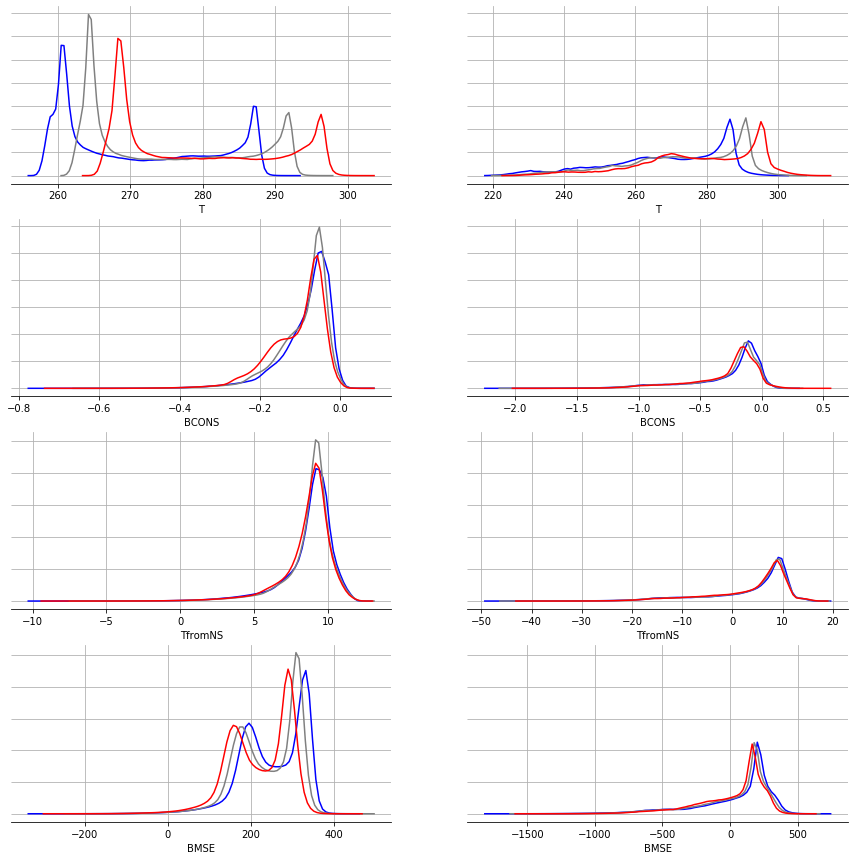

In [36]:
fig,ax = plt.subplots(4,2,figsize=(15,15))

#plt.subplots_adjust(wspace=None, hspace=-0.025)

for iconfig in range(2):
    if iconfig==0: path0 = path_aqua
    elif iconfig==1: path0 = path_RG
    print('iconfig=',iconfig)
    
    for ipath,path in enumerate(path0):
        print('ipath=',ipath,'path=',path)
        for iT,Tvar in enumerate(Tarray):
            ax[iT,iconfig].plot(edg2bin(edgT[Tvar][path]),
                                hisT[Tvar][path],
                                color=color_array[ipath])
            ax[iT,iconfig].set_xlabel(Tvar)
            
plt.draw()

for iT,Tvar in enumerate(Tarray):
    YLIM_MIN = 1e9; YLIM_MAX = 0 # Initialization
    for iconfig in range(2):
        YLIM = ax[iT,iconfig].get_ylim()
        YLIM_MIN = np.minimum(YLIM_MIN,YLIM[0])
        YLIM_MAX = np.maximum(YLIM_MAX,YLIM[1])
    for iconfig in range(2):
        ax[iT,iconfig].set_ylim((YLIM_MIN,YLIM_MAX))
        ax[iT,iconfig].grid()
        ax[iT,iconfig].yaxis.set_major_formatter(NullFormatter())
        ax[iT,iconfig].tick_params(axis='y', colors='white')
        for ipos,pos in enumerate(['top','right','left']):
            ax[iT,iconfig].spines[pos].set_visible(False)

# Calculate and Save PDFs for different rescalings & different simulations/climates

Follows the end of [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/064_Convert_Outputs_to_Percentiles_Univariate_PDF.ipynb]

## Load Datasets of interest

In [4]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [5]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

In [6]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
     '2021_06_03_RG_TRAIN_shuffle.nc',
     '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
     '2021_04_18_RG_TRAIN_P4K_shuffle.nc'
]

In [7]:
ishift = [0,0,0,-30,-30,-30]

In [8]:
train_data = {}

In [9]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'     ',end='\n')
    
    path_var = path_data + path 
    train_data[path] = xr.open_dataset(path_var)

ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc      
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc      
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc      
ipath= 3 path= 2021_06_03_RG_TRAIN_shuffle.nc      
ipath= 4 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc      
ipath= 5 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc      


## Load Coordinates

In [10]:
# Comet path below
# TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
# path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'

# GP path below
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path = '/export/nfs0home/tbeucler/CBRAIN-CAM/cbrain/'
path_nnconfig = '/export/nfs0home/tbeucler/CBRAIN-CAM/nn_config/'

# Load hyam and hybm to calculate pressure field in SPCAM
path_hyam = 'hyam_hybm.pkl'
hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

# Scale dictionary to convert the loss to W/m2
scale_dict = pickle.load(open(path_nnconfig+'scale_dicts/009_Wm2_scaling.pkl','rb'))

In [11]:
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [12]:
pathRG_m4K = '/DFS-L/DATA/pritchard/liranp/SST_4Km_Neuralnet_SPCAM_all_small_216/atm/hist/'
coor = xr.open_dataset(pathRG_m4K+'SST_4Km_Neuralnet_SPCAM_all_small_216.cam.h1.2009-12-29-72000.nc')

lat_RG = coor.lat; lon_RG = coor.lon; lev_RG = coor.lev;
coor.close();

## Load distributions saved in PKL format if available

In [12]:
save_name_Q = '2021_06_07_AQUA_RG_Qhist'
Q_data = pickle.load(open(pathPKL+'/'+save_name_Q+'.pkl','rb'))

In [13]:
save_name_T = '2021_06_07_AQUA_RG_Thist'
T_data = pickle.load(open(pathPKL+'/'+save_name_T+'.pkl','rb'))

In [49]:
save_name_LHF = '2021_06_07_AQUA_RG_LHFhist'
LHF_data = pickle.load(open(pathPKL+'/'+save_name_LHF+'.pkl','rb'))

## Q vs QfromQSAT vs RH

In [15]:
def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)
    return Rv*p*qv/(R*esat(T))

def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)

    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

def QfromQsat(qv,T,P0,PS,hyam,hybm):
    return qsat(T,P0,PS,hyam,hybm)-qv

In [16]:
ilev = 19 # Choose vertical level here

In [17]:
hisQ = {}
edgQ = {}

for ikey,key in enumerate(['QV','RH','QfromQsat']):
    hisQ[key] = {}
    edgQ[key] = {}
    for ipath,path in enumerate(path_array):
        hisQ[key][path] = {}
        edgQ[key][path] = {}

In [18]:
Nbin = 100

In [19]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'ilev=',ilev)
    
    print('Load state variables')
    print('QV              ',end='\r')
    QV = train_data[path]['vars'][:,ilev]
    QV = QV.values
    print('TEMP              ',end='\r')
    TEMP = train_data[path]['vars'][:,30+ilev]
    TEMP = TEMP.values
    print('PS              ',end='\r')
    PS = train_data[path]['vars'][:,90+ishift[ipath]]
    PS = PS.values
    
    print('Calculate relevant rescalings')
    print('RH              ',end='\r')
    RH0 = RH(TEMP,QV,P0,PS,hyam[ilev],hybm[ilev])
    print('QfromQSAT              ',end='\r')
    QfromQSAT0 = QfromQsat(QV,TEMP,P0,PS,hyam[ilev],hybm[ilev])
    
    print('Calculate histogram and assign it to histogram structure')
    for ikey,key in enumerate(['QV','RH','QfromQsat']):
        if key=='QV': his,edg = np.histogram(QV,bins=Nbin,density=True)
        elif key=='RH': his,edg = np.histogram(RH0,bins=Nbin,density=True)
        elif key=='QfromQsat': his,edg = np.histogram(QfromQSAT0,bins=Nbin,density=True)
        hisQ[key][path] = his; edgQ[key][path] = edg;

ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc ilev= 19
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc ilev= 19
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc ilev= 19
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 3 path= 2021_06_03_RG_TRAIN_shuffle.nc ilev= 19
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 4 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc ilev= 19
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 5 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc ilev= 19
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure


In [12]:
save_name = '2021_06_07_AQUA_RG_Qhist'

In [21]:
# hf = open(pathPKL+'/'+save_name+'.pkl','wb')

# F_data = {'hisQ':hisQ,'edgQ':edgQ,'path_array':path_array,'ilev':ilev}

# pickle.dump(F_data,hf)
# hf.close()

## T vs BCONS vs TfromTS

In [13]:
def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))
def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)

    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

def theta_e_calc(T,qv,P0,PS,hyam,hybm):
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)

    tmelt  = 273.15
    CPD = 1005.7
    CPV = 1870.0
    CPVMCL = 2320.0
    RV = 461.5
    RD = 287.04
    EPS = RD/RV
    ALV0 = 2.501E6

    r = qv / (1. - qv)
    # get ev in hPa 
    ev_hPa = 100*p*r/(EPS+r)
    #get TL
    TL = (2840. / ((3.5*np.log(T)) - (np.log(ev_hPa)) - 4.805)) + 55.
    #calc chi_e:
    chi_e = 0.2854 * (1. - (0.28*r))
    P0_norm = (P0/(hyam*P0+hybm*PS))

    theta_e = T * P0_norm**chi_e * np.exp(((3.376/TL) - 0.00254) * r * 1000. * (1. + (0.81 * r)))

    return theta_e

def theta_e_sat_calc(T,qv,P0,PS,hyam,hybm):
    return theta_e_calc(T,qsat(T,P0,PS,hyam,hybm),P0,PS,hyam,hybm)

def bcons(T,qv,ilev,P0,PS,hyam,hybm,TNS,QNS):
    theta_env = theta_e_sat_calc(T,qv,P0,PS,hyam[ilev],hybm[ilev])
    return G*(theta_e_calc(TNS,QNS,P0,PS,hyam[29],hybm[29])-theta_env)/theta_env

def TfromNS(T,TNS):
    return TNS-T

In [20]:
ilev = 10 # Choose vertical level here

In [21]:
hisT = {}
edgT = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = {}
        edgT[key][path] = {}

In [22]:
Nbin = 100

In [23]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path,'ilev=',ilev)
    
    print('Load state variables')
    print('QV              ',end='\r')
    QV = train_data[path]['vars'][:,ilev]
    QV = QV.values
    print('TEMP              ',end='\r')
    TEMP = train_data[path]['vars'][:,30+ilev]
    TEMP = TEMP.values
    print('PS              ',end='\r')
    PS = train_data[path]['vars'][:,90+ishift[ipath]]
    PS = PS.values
    print('TNS             ',end='\r')
    TNS = train_data[path]['vars'][:,30+29]
    TNS = TNS.values
    print('QNS             ',end='\r')
    QNS = train_data[path]['vars'][:,29]
    QNS = QNS.values
    
    print('Calculate relevant rescalings')
    print('BCONS              ',end='\r')
    BCONS0 = bcons(TEMP,QV,ilev,P0,PS,hyam,hybm,TNS,QNS)
    print('TfromNS              ',end='\r')
    TfromNS0 = TfromNS(TEMP,TNS)
    
    print('Calculate histogram and assign it to histogram structure')
    for ikey,key in enumerate(['T','BCONS','TfromNS']):
        if key=='T': his,edg = np.histogram(TEMP,bins=Nbin,density=True)
        elif key=='BCONS': his,edg = np.histogram(BCONS0,bins=Nbin,density=True)
        elif key=='TfromNS': his,edg = np.histogram(TfromNS0,bins=Nbin,density=True)
        hisT[key][path] = his; edgT[key][path] = edg;

ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc ilev= 10
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc ilev= 10
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc ilev= 10
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 3 path= 2021_06_03_RG_TRAIN_shuffle.nc ilev= 10
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 4 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc ilev= 10
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 5 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc ilev= 10
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure


In [24]:
save_name = '2021_08_18_AQUA_RG_Thist_ilev'+str(ilev)

In [25]:
hf = open(pathPKL+'/'+save_name+'.pkl','wb')

F_data = {'hisT':hisT,'edgT':edgT,'path_array':path_array}

pickle.dump(F_data,hf)
hf.close()

## LHF vs LHFbyQNS vs LHFbyDELQ

In [39]:
def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS) # Total pressure (Pa)

    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

def LHF_nsQ(LHF,QNS,eps):
    return LHF/(L_V*np.maximum(eps,QNS))

def LHF_nsDELQ(LHF,QNS,TNS,PS,P0,hyam,hybm,eps):
    return LHF/(L_V*np.maximum(eps,(qsat(TNS,P0,PS,hyam[-1],hybm[-1])-QNS)))

In [40]:
hisLHF = {}
edgLHF = {}

for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
    hisLHF[key] = {}
    edgLHF[key] = {}
    for ipath,path in enumerate(path_array):
        hisLHF[key][path] = {}
        edgLHF[key][path] = {}

In [41]:
Nbin = 100
eps = 1e-3

In [43]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path)
    
    print('Load state variables')
    print('LHF              ',end='\r')
    LHF = train_data[path]['vars'][:,93+ishift[ipath]]
    LHF = LHF.values
    print('PS              ',end='\r')
    PS = train_data[path]['vars'][:,90+ishift[ipath]]
    PS = PS.values
    print('TNS             ',end='\r')
    TNS = train_data[path]['vars'][:,30+29]
    TNS = TNS.values
    print('QNS             ',end='\r')
    QNS = train_data[path]['vars'][:,29]
    QNS = QNS.values
    
    print('Calculate relevant rescalings')
    print('LHF_nsQ                 ',end='\r')
    LHF_nsQ0 = LHF_nsQ(LHF,QNS,eps)
    print('LHF_nsDELQ              ',end='\r')
    LHF_nsDELQ0 = LHF_nsDELQ(LHF,QNS,TNS,PS,P0,hyam,hybm,eps)
    
    print('Calculate histogram and assign it to histogram structure')
    for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
        if key=='LHF': his,edg = np.histogram(LHF,bins=Nbin,density=True)
        elif key=='LHF_nsQ': his,edg = np.histogram(LHF_nsQ0,bins=Nbin,density=True)
        elif key=='LHF_nsDELQ': his,edg = np.histogram(LHF_nsDELQ0,bins=Nbin,density=True)
        hisLHF[key][path] = his; edgLHF[key][path] = edg;

ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 3 path= 2021_06_03_RG_TRAIN_shuffle.nc
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 4 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure
ipath= 5 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc
Load state variables
Calculate relevant rescalings
Calculate histogram and assign it to histogram structure


In [44]:
save_name = '2021_06_07_AQUA_RG_LHFhist'

In [45]:
hf = open(pathPKL+'/'+save_name+'.pkl','wb')

F_data = {'hisLHF':hisLHF,'edgLHF':edgLHF,'path_array':path_array}

pickle.dump(F_data,hf)
hf.close()

## SHF and ps histograms for supplemental material

In [13]:
hisSM = {}
edgSM = {}

for ikey,key in enumerate(['SHF','ps']):
    hisSM[key] = {}
    edgSM[key] = {}
    for ipath,path in enumerate(path_array):
        hisSM[key][path] = {}
        edgSM[key][path] = {}

In [14]:
Nbin = 100

In [16]:
for ipath,path in enumerate(path_array):
    print('ipath=',ipath,'path=',path)
    
    print('Load state variables')
    print('SHF              ',end='\r')
    SHF = train_data[path]['vars'][:,92+ishift[ipath]]
    SHF = SHF.values
    print('PS              ',end='\r')
    PS = train_data[path]['vars'][:,90+ishift[ipath]]
    PS = PS.values
    
    print('Calculate histogram and assign it to histogram structure')
    for ikey,key in enumerate(['SHF','ps']):
        if key=='SHF': his,edg = np.histogram(SHF,bins=Nbin,density=True)
        elif key=='ps': his,edg = np.histogram(PS,bins=Nbin,density=True)
        hisSM[key][path] = his; edgSM[key][path] = edg;

ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc
Load state variables
Calculate histogram and assign it to histogram structure
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc
Load state variables
Calculate histogram and assign it to histogram structure
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc
Load state variables
Calculate histogram and assign it to histogram structure
ipath= 3 path= 2021_06_03_RG_TRAIN_shuffle.nc
Load state variables
Calculate histogram and assign it to histogram structure
ipath= 4 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc
Load state variables
Calculate histogram and assign it to histogram structure
ipath= 5 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc
Load state variables
Calculate histogram and assign it to histogram structure


In [17]:
save_name = '2021_09_16_AQUA_RG_SMhist'

In [18]:
# hf = open(pathPKL+'/'+save_name+'.pkl','wb')

# F_data = {'hisSM':hisSM,'edgSM':edgSM,'path_array':path_array}

# pickle.dump(F_data,hf)
# hf.close()

# Summary Figure

In [86]:
path_aqua = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc'
]
path_RG = [
    '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
    '2021_06_03_RG_TRAIN_shuffle.nc',
    '2021_04_18_RG_TRAIN_P4K_shuffle.nc'
]
color_array = ['b','gray','red']
Qarray = ['QV','RH','QfromQsat']
Tarray = ['T','BCONS','TfromNS']
LHFarray = ['LHF','LHF_nsQ','LHF_nsDELQ']

## Load data

Load Q

In [93]:
pathPKL = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/PKL_DATA/'

In [94]:
save_name = '2021_06_07_AQUA_RG_Qhist'

In [95]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

Q_data = pickle.load(hf)
hf.close()

Load T

In [96]:
save_name = '2021_06_07_AQUA_RG_Thist'

In [97]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

T_data = pickle.load(hf)
hf.close()

Load B

In [98]:
path = '2021_06_21_distributions_BMSE'

In [99]:
hf = open(pathPKL+'/'+path+'.pkl','rb')

B_data = pickle.load(hf)
hf.close()

Load LHF

In [100]:
save_name = '2021_06_07_AQUA_RG_LHFhist'

In [101]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

LHF_data = pickle.load(hf)
hf.close()

Load hypohydrostatic histograms

In [102]:
fol_Janni = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/Janni_data/'

In [103]:
Q_data_HH = pickle.load(open(fol_Janni+'q_hists.pkl','rb'))

In [106]:
HHdic = {}
HHdic['QV'] = 'qv';
HHdic['RH'] = 'RH';
HHdic['QfromQsat'] = 'q_deficit'

In [109]:
T_data_HH = pickle.load(open(fol_Janni+'T_hists.pkl','rb'))

In [110]:
T_data_HH['edgQ'].keys()

dict_keys(['Tin', 'BMSE', 'T_mTNS'])

In [122]:
HHdic['T'] = 'Tin'
HHdic['BMSE'] = 'BMSE'
HHdic['TfromNS'] = 'T_mTNS'

## Group all variables into the same structure

In [112]:
hisQ = {}
edgQ = {}

for ikey,key in enumerate(['QV','RH','QfromQsat']):
    hisQ[key] = {}
    edgQ[key] = {}
    for ipath,path in enumerate(path_array):
        hisQ[key][path] = {}
        edgQ[key][path] = {}

In [113]:
hisT = {}
edgT = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = {}
        edgT[key][path] = {}

In [114]:
hisLHF = {}
edgLHF = {}

for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
    hisLHF[key] = {}
    edgLHF[key] = {}
    for ipath,path in enumerate(path_array):
        hisLHF[key][path] = {}
        edgLHF[key][path] = {}

In [115]:
hisQ = Q_data['hisQ']
edgQ = Q_data['edgQ']
# Convert specific humidities to g/kg
for ipath,path0 in enumerate(path_array):
    for ikey,key in enumerate(['QV','QfromQsat']):
        edgQ[key][path0] *= 1e3

hisT = T_data['hisT']
edgT = T_data['edgT']
# Load buoyancy from MSE
ilevB = 23
for ikey,key in enumerate(['BMSE']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = B_data['hisT'][ilevB][path]
        edgT[key][path] = B_data['edgT'][ilevB][path]
# Redefine Tarray to replace BCONS with BMSE for now
Tarray = ['T','BMSE','TfromNS']

hisLHF = LHF_data['hisLHF']
edgLHF = LHF_data['edgLHF']

## Set histograms to zero for the (-4K) SAM simulations and load Janni values for the other sims

In [117]:
hisQ.keys()

dict_keys(['QV', 'RH', 'QfromQsat'])

In [150]:
path_SAM = ['1','2','3']
for ipath,path0 in enumerate(path_SAM):
    
    for ikey,key in enumerate(['QV','RH','QfromQsat']):
        if ipath==2: 
            edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs']
            hisQ[key][path0] = 0*edg2bin(edgQ[key][path0])**0
        elif ipath==0: 
            hisQ[key][path0] = Q_data_HH['hisQ'][HHdic[key]]['qobs']
            if key=='RH': edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs']
            else: edgQ[key][path0] = 1e3*Q_data_HH['edgQ'][HHdic[key]]['qobs'] # Conversion in g/kg
        elif ipath==1: 
            hisQ[key][path0] = Q_data_HH['hisQ'][HHdic[key]]['qobs4K']
            if key=='RH': edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs4K']
            else: edgQ[key][path0] = 1e3*Q_data_HH['edgQ'][HHdic[key]]['qobs4K'] # Conversion in g/kg
    
    for ikey,key in enumerate(['T','BMSE','TfromNS']):
        if ipath==2: 
            edgT[key][path0] = T_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT[key][path0] = 0*edg2bin(edgT[key][path0])**0
        elif ipath==0: 
            hisT[key][path0] = T_data_HH['hisQ'][HHdic[key]]['qobs']
            edgT[key][path0] = T_data_HH['edgQ'][HHdic[key]]['qobs']
        elif ipath==1: 
            hisT[key][path0] = T_data_HH['hisQ'][HHdic[key]]['qobs4K']
            edgT[key][path0] = T_data_HH['edgQ'][HHdic[key]]['qobs4K']

## Q alone

In [26]:
dir(ax[iQ,iconfig])

NameError: name 'ax' is not defined

In [ ]:
fig,ax = plt.subplots(3,2,figsize=(15,15))

for iconfig in range(2):
    if iconfig==0: path0 = path_aqua
    elif iconfig==1: path0 = path_RG
    print('iconfig=',iconfig)
    
    for ipath,path in enumerate(path0):
        print('ipath=',ipath,'path=',path)
        for iQ,Qvar in enumerate(Qarray):
            ax[iQ,iconfig].plot(edg2bin(edgQ[Qvar][path]),
                                hisQ[Qvar][path],
                                color=color_array[ipath])
            ax[iQ,iconfig].set_xlabel(Qvar)
                
plt.draw()

for iQ,Qvar in enumerate(Qarray):
    YLIM_MIN = 1e9; YLIM_MAX = 0 # Initialization
    for iconfig in range(2):
        YLIM = ax[iQ,iconfig].get_ylim()
        YLIM_MIN = np.minimum(YLIM_MIN,YLIM[0])
        YLIM_MAX = np.maximum(YLIM_MAX,YLIM[1])
    for iconfig in range(2):
        ax[iQ,iconfig].set_ylim((YLIM_MIN,YLIM_MAX))
        ax[iQ,iconfig].grid()
        ax[iQ,iconfig].yaxis.set_major_formatter(NullFormatter())
        ax[iQ,iconfig].tick_params(axis='y', colors='white')
        for ipos,pos in enumerate(['top','right','left']):
            ax[iQ,iconfig].spines[pos].set_visible(False)

## T alone

iconfig= 0
ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc
iconfig= 1
ipath= 0 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc
ipath= 1 path= 2021_06_03_RG_TRAIN_shuffle.nc
ipath= 2 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc


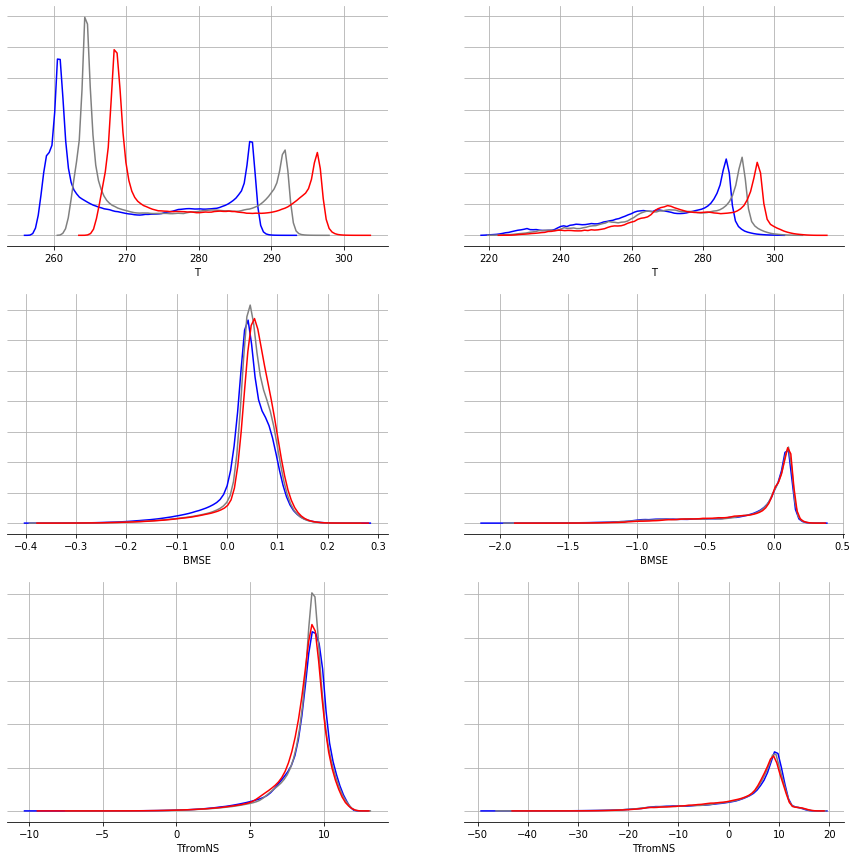

In [27]:
fig,ax = plt.subplots(3,2,figsize=(15,15))

#plt.subplots_adjust(wspace=None, hspace=-0.025)

for iconfig in range(2):
    if iconfig==0: path0 = path_aqua
    elif iconfig==1: path0 = path_RG
    print('iconfig=',iconfig)
    
    for ipath,path in enumerate(path0):
        print('ipath=',ipath,'path=',path)
        for iT,Tvar in enumerate(Tarray):
            ax[iT,iconfig].plot(edg2bin(edgT[Tvar][path]),
                                hisT[Tvar][path],
                                color=color_array[ipath])
            ax[iT,iconfig].set_xlabel(Tvar)
            
plt.draw()

for iT,Tvar in enumerate(Tarray):
    YLIM_MIN = 1e9; YLIM_MAX = 0 # Initialization
    for iconfig in range(2):
        YLIM = ax[iT,iconfig].get_ylim()
        YLIM_MIN = np.minimum(YLIM_MIN,YLIM[0])
        YLIM_MAX = np.maximum(YLIM_MAX,YLIM[1])
    for iconfig in range(2):
        ax[iT,iconfig].set_ylim((YLIM_MIN,YLIM_MAX))
        ax[iT,iconfig].grid()
        ax[iT,iconfig].yaxis.set_major_formatter(NullFormatter())
        ax[iT,iconfig].tick_params(axis='y', colors='white')
        for ipos,pos in enumerate(['top','right','left']):
            ax[iT,iconfig].spines[pos].set_visible(False)

## LHF alone

iconfig= 0
ipath= 0 path= 2021_03_18_O3_TRAIN_M4K_shuffle.nc
ipath= 1 path= 2021_01_24_O3_TRAIN_shuffle.nc
ipath= 2 path= 2021_03_18_O3_TRAIN_P4K_shuffle.nc
iconfig= 1
ipath= 0 path= 2021_04_18_RG_TRAIN_M4K_shuffle.nc
ipath= 1 path= 2021_06_03_RG_TRAIN_shuffle.nc
ipath= 2 path= 2021_04_18_RG_TRAIN_P4K_shuffle.nc


/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchar

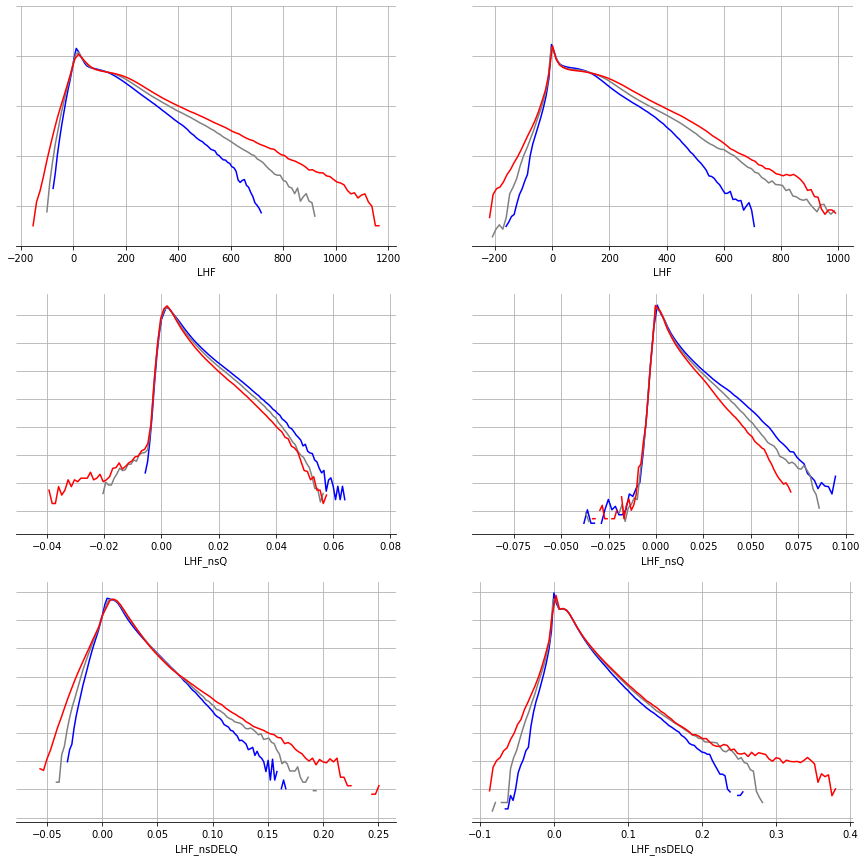

In [28]:
fig,ax = plt.subplots(3,2,figsize=(15,15))

#plt.subplots_adjust(wspace=None, hspace=-0.025)

for iconfig in range(2):
    if iconfig==0: path0 = path_aqua
    elif iconfig==1: path0 = path_RG
    print('iconfig=',iconfig)
    
    for ipath,path in enumerate(path0):
        print('ipath=',ipath,'path=',path)
        for iLHF,LHFvar in enumerate(LHFarray):
            ax[iLHF,iconfig].plot(edg2bin(edgLHF[LHFvar][path]),
                                np.log10(hisLHF[LHFvar][path]),
                                color=color_array[ipath])
            ax[iLHF,iconfig].set_xlabel(LHFvar)
                
plt.draw()

for iLHF,LHFvar in enumerate(LHFarray):
    YLIM_MIN = 1e9; YLIM_MAX = 0 # IniLHFialization
    for iconfig in range(2):
        YLIM = ax[iLHF,iconfig].get_ylim()
        YLIM_MIN = np.minimum(YLIM_MIN,YLIM[0])
        YLIM_MAX = np.maximum(YLIM_MAX,YLIM[1])
    for iconfig in range(2):
        ax[iLHF,iconfig].set_ylim((YLIM_MIN,YLIM_MAX))
        ax[iLHF,iconfig].grid()
        ax[iLHF,iconfig].yaxis.set_major_formatter(NullFormatter())
        ax[iLHF,iconfig].tick_params(axis='y', colors='white')
        for ipos,pos in enumerate(['top','right','left']):
            ax[iLHF,iconfig].spines[pos].set_visible(False)

## All variables together

In [124]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

plot_log = [True,True,True]

In [125]:
YLAB = {}

YLAB[0] = {}
YLAB[0]['QV'] = '$q\\ \\left[\\mathrm{g\\ kg^{-1}}\\right]$'
YLAB[0]['RH'] = '$\\mathrm{RH}\\ \\left[1\\right]$'
YLAB[0]['QfromQsat'] = '$q_{\\mathrm{deficit}}\\ \\left[\\mathrm{g\\ kg^{-1}}\\right]$'

YLAB[1] = {}
YLAB[1]['T'] = '$T\\ \\left[\\mathrm{K}\\right]$'
YLAB[1]['BMSE'] = '$B_{\\mathrm{plume}}\\ \\left[\\mathrm{m\\ s^{-2}}\\right]$'
YLAB[1]['TfromNS'] = '$T_{\\mathrm{from\\ NS}}\\ \\left[\\mathrm{K}\\right]$'

YLAB[2] = {}
YLAB[2]['LHF'] = '$\\mathrm{LHF}\\ \\left[\\mathrm{W\\ m^{-2}}\\right]$'
YLAB[2]['LHF_nsQ'] = '$\\mathrm{LHF}_{q}\\ \\left[\\mathrm{kg\\ m^{-2}\\ s^{-1}}\\right]$'
YLAB[2]['LHF_nsDELQ'] = '$\\mathrm{LHF}_{\\Delta q}\\ \\left[\\mathrm{kg\\ m^{-2}\\ s^{-1}}\\right]$'

In [126]:
Y0 = 1.2
TITLE = ["Aquaplanet (SPCAM3)","Earth-like (SPCAM5)","Hypohydrostatic (SAM)"]
PANEL = ['(a)','(b)','(c)']

In [130]:
toplot.shape

(100,)

In [131]:
edg2bin(edg[resc][path]).shape

(99,)

ivar= 0 VARarray= ['QV', 'QfromQsat', 'RH']
ivar= 1 VARarray= ['T', 'TfromNS', 'BMSE']
ivar= 2 VARarray= ['LHF', 'LHF_nsQ', 'LHF_nsDELQ']


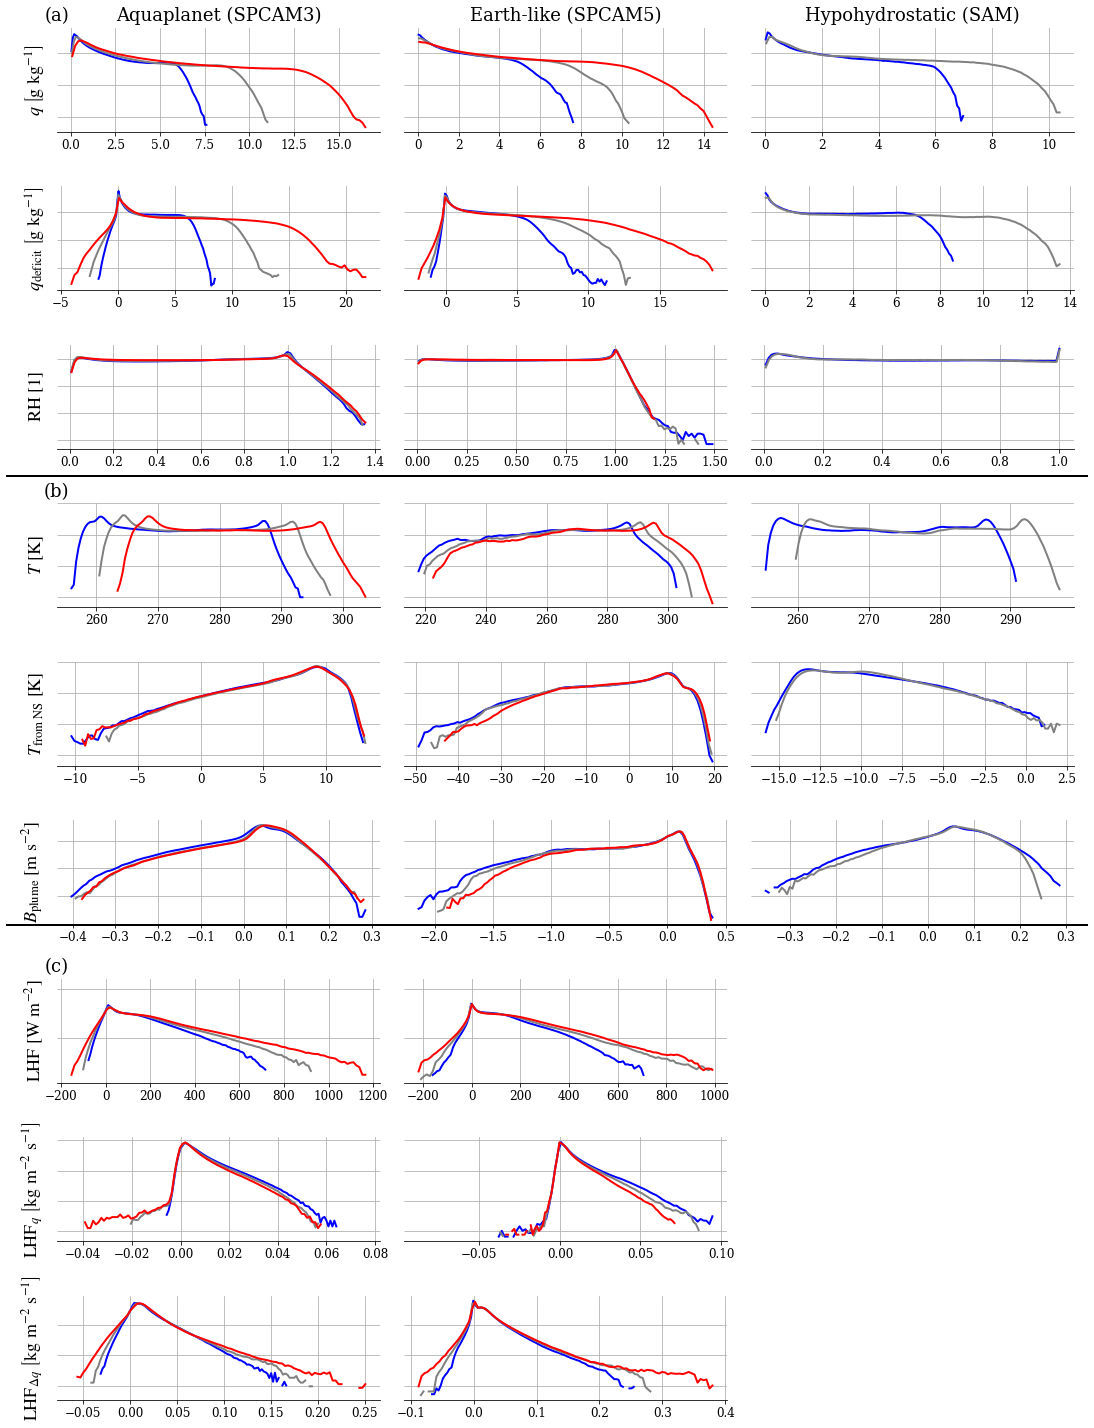

In [152]:
fig,ax = plt.subplots(9,3,figsize=(15,20))

warnings.filterwarnings("ignore") # We are taking the log of zero to facilitate visualization of certain PDFs

for ivar in range(3):
    if ivar==0: VARarray = ['QV','QfromQsat','RH']; edg = edgQ; his = hisQ;
    elif ivar==1: VARarray = ['T','TfromNS','BMSE']; edg = edgT; his = hisT;
    elif ivar==2: VARarray = LHFarray; edg = edgLHF; his  = hisLHF;
    print('ivar=',ivar,'VARarray=',VARarray)
        
    for iconfig in range(3):
        if iconfig==0: path0 = path_aqua
        elif iconfig==1: path0 = path_RG
        elif iconfig==2: path0 = path_SAM

        for ipath,path in enumerate(path0):
            for iresc,resc in enumerate(VARarray):
                
                if iconfig==2 and ivar==2:
                    if ipath==0:
                        fig.delaxes(ax[3*ivar+iresc,iconfig]);
                else:
                    if plot_log[ivar]: toplot = np.log10(his[resc][path])
                    else: toplot = his[resc][path]

                    ax[3*ivar+iresc,iconfig].plot(edg2bin(edg[resc][path]),
                                                  toplot,
                                                  color=color_array[ipath])

    plt.draw()

    for iresc,resc in enumerate(VARarray):
        YLIM_MIN = 1e9; YLIM_MAX = 0 # Initialization
        for iconfig in range(3):
            YLIM = ax[3*ivar+iresc,iconfig].get_ylim()
            YLIM_MIN = np.minimum(YLIM_MIN,YLIM[0])
            YLIM_MAX = np.maximum(YLIM_MAX,YLIM[1])
        for iconfig in range(3):
            ax[3*ivar+iresc,iconfig].set_ylim((YLIM_MIN,YLIM_MAX))
            ax[3*ivar+iresc,iconfig].grid()
            ax[3*ivar+iresc,iconfig].yaxis.set_major_formatter(NullFormatter())
            ax[3*ivar+iresc,iconfig].tick_params(axis='y', colors='white')
            for ipos,pos in enumerate(['top','right','left']):
                ax[3*ivar+iresc,iconfig].spines[pos].set_visible(False)
            
            if iconfig==0: ax[3*ivar+iresc,iconfig].set_ylabel(YLAB[ivar][resc],fontsize=1.5*fz)
                
# Title of each column and letters of each panel
for iconfig in range(3):
    ax[0][iconfig].text(0.5,Y0,TITLE[iconfig],va='top',ha = 'center',
                        transform = ax[0][iconfig].transAxes,fontsize=1.5*fz)

for ivar in range(3):
    ax[3*ivar][0].text(0,Y0,PANEL[ivar],va='top',ha = 'center',
                       transform = ax[3*ivar][0].transAxes,fontsize=1.5*fz)

# Draw separators between three variables
# Adapted from [https://stackoverflow.com/questions/26084231/draw-a-separator-or-lines-between-subplots]
# rearange the axes for no overlap
fig.tight_layout()

# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, ax.flat)), mtrans.Bbox).reshape(ax.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(ax.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(ax.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys[[2,5]]:
    line = plt.Line2D([0,1],[y,y], transform=fig.transFigure, color="black")
    fig.add_artist(line)

## Just SHF and ps for SPCAM3 and SPCAM5 without rescaling

In [53]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

TITLE = ["Aquaplanet (SPCAM3)","Earth-like (SPCAM5)"]
Y0 = 1.2

plot_log = [True,True]

In [54]:
YLAB = {}

YLAB[0] = {}
YLAB[0]['SHF'] = '$\\mathrm{SHF}\\ \\left[\\mathrm{W\\ m^{-2}}\\right]$'

YLAB[1] = {}
YLAB[1]['ps'] = '$p_{s}\\ \\left[\\mathrm{hPa}\\right]$'

ivar= 0 VARarray= ['SHF']
ivar= 1 VARarray= ['ps']


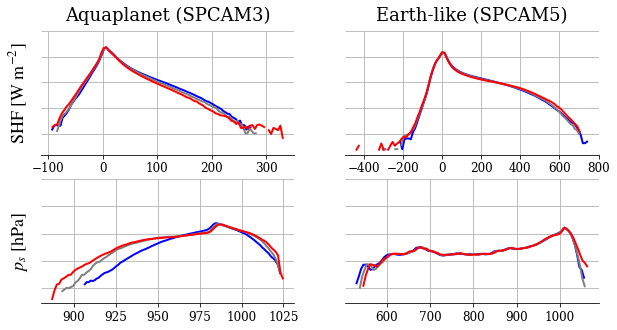

In [58]:
fig,ax = plt.subplots(2,2,figsize=(10,5))

warnings.filterwarnings("ignore") # We are taking the log of zero to facilitate visualization of certain PDFs
his = hisSM;
edg = edgSM;

for ivar in range(2):
    if ivar==0: VARarray = ['SHF']; scaling = 1;
    elif ivar==1: VARarray = ['ps']; scaling = 1e2; # Conversion from Pa to hPa
    print('ivar=',ivar,'VARarray=',VARarray)
        
    for iconfig in range(2):
        if iconfig==0: path0 = path_aqua
        elif iconfig==1: path0 = path_RG

        for ipath,path in enumerate(path0):
            for iresc,resc in enumerate(VARarray):
                
                if plot_log[ivar]: toplot = np.log10(his[resc][path])
                else: toplot = his[resc][path]
                
                ax[ivar+iresc,iconfig].plot(edg2bin(edg[resc][path])/scaling,
                                              toplot,color=color_array[ipath])

    plt.draw()

    for iresc,resc in enumerate(VARarray):
        YLIM_MIN = 1e9; YLIM_MAX = 0 # Initialization
        for iconfig in range(2):
            YLIM = ax[ivar+iresc,iconfig].get_ylim()
            YLIM_MIN = np.minimum(YLIM_MIN,YLIM[0])
            YLIM_MAX = np.maximum(YLIM_MAX,YLIM[1])
        for iconfig in range(2):
            ax[ivar+iresc,iconfig].set_ylim((YLIM_MIN,YLIM_MAX))
            ax[ivar+iresc,iconfig].grid()
            ax[ivar+iresc,iconfig].yaxis.set_major_formatter(NullFormatter())
            ax[ivar+iresc,iconfig].tick_params(axis='y', colors='white')
            for ipos,pos in enumerate(['top','right','left']):
                ax[ivar+iresc,iconfig].spines[pos].set_visible(False)
            
            if iconfig==0: ax[ivar+iresc,iconfig].set_ylabel(YLAB[ivar][resc],fontsize=1.5*fz)
                
# Title of each column and letters of each panel
for iconfig in range(2):
    ax[0][iconfig].text(0.5,Y0,TITLE[iconfig],va='top',ha = 'center',
                        transform = ax[0][iconfig].transAxes,fontsize=1.5*fz)